In [69]:
# Imports
import pandas as pd
import numpy as np
import datetime
from datetime import time as dtime
from datetime import timedelta
from datetime import date
import matplotlib as plt
from itertools import product
import openpyxl

# importing historical data for backtest
def get1minBars(csvName):
    
    priceData1minBars_df = pd.read_csv(csvName, usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
    
    # Parse datetime column and divide in 2 columns
    # SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
    priceData1minBars_df.rename(columns={
        'date': 'datetime'
    }, inplace=True)
    
    priceData1minBars_df['datetime'] = pd.to_datetime(priceData1minBars_df['datetime'])
    
    priceData1minBars_df['Date'] = priceData1minBars_df['datetime'].dt.date
    priceData1minBars_df['Time'] = priceData1minBars_df['datetime'].dt.time
    
    # sorting the data by the time column to make sure it is consistent
    priceData1minBars_df.sort_values('datetime', inplace=True)
    
    # Drop original 'date' column
    # SPY_Data.drop(columns=['date'], inplace=True)
    
    # Filter for regular trading hours using datetime column
    # priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time >= pd.to_datetime("09:30").time()]
    # priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time <= pd.to_datetime("16:00").time()]
    
    # Making sure the order of the columns stays the same 
    priceData1minBars_df = priceData1minBars_df[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
    
    return priceData1minBars_df
    
    
NQ_Data = get1minBars('NQ_1min_master.csv')
# QQQ_Data = QQQ_Data[472980:483000]
NQ_Data = NQ_Data[:int(len(NQ_Data)/2)]
NQ_Data

,Date,Time,open,high,low,close,volume
0,2023-11-01,22:00:00,14761.25,14763.50,14760.00,14760.00,175
1,2023-11-01,22:01:00,14760.50,14764.00,14760.50,14762.00,156
2,2023-11-01,22:02:00,14762.25,14762.25,14760.50,14761.25,48
3,2023-11-01,22:03:00,14761.25,14762.00,14760.75,14761.00,30
4,2023-11-01,22:04:00,14761.75,14763.00,14761.00,14762.25,52
...,...,...,...,...,...,...,...
353281,2024-10-31,15:47:00,20059.50,20060.00,20042.25,20047.50,2006
353282,2024-10-31,15:48:00,20047.50,20052.00,20035.75,20042.75,2235
353283,2024-10-31,15:49:00,20042.50,20044.75,20036.25,20040.25,1373
353284,2024-10-31,15:50:00,20040.25,20046.75,20034.00,20040.00,1524


In [70]:
import numpy as np
import pandas as pd
from datetime import time as dtime

# ------- Minimal ADX helper (used only if DIp14/60, DIn14/60, ADX14/60 not already present) -------
def _compute_adx_block(df, n=14, per_session=True):
    out = df.copy()
    if per_session:
        prev_high = out.groupby('Date')['high'].shift(1)
        prev_low  = out.groupby('Date')['low'].shift(1)
        prev_close= out.groupby('Date')['close'].shift(1)
    else:
        prev_high = out['high'].shift(1)
        prev_low  = out['low'].shift(1)
        prev_close= out['close'].shift(1)

    up_move   = out['high'] - prev_high
    down_move = prev_low - out['low']
    plus_dm   = np.where((up_move > 0) & (up_move > down_move), up_move, 0.0)
    minus_dm  = np.where((down_move > 0) & (down_move > up_move), down_move, 0.0)
    plus_dm   = pd.Series(plus_dm, index=out.index)
    minus_dm  = pd.Series(minus_dm, index=out.index)

    tr1 = (out['high'] - out['low']).abs()
    tr2 = (out['high'] - prev_close).abs()
    tr3 = (out['low'] - prev_close).abs()
    tr = np.maximum(tr1, np.maximum(tr2, tr3)).fillna(tr1)

    def _smooth(s, n_):
        return s.ewm(alpha=1/n_, adjust=False).mean()

    if per_session:
        tr_n      = tr.groupby(out['Date']).transform(lambda s: _smooth(s, n))
        plus_dm_n = plus_dm.groupby(out['Date']).transform(lambda s: _smooth(s, n))
        minus_dm_n= minus_dm.groupby(out['Date']).transform(lambda s: _smooth(s, n))
    else:
        tr_n      = _smooth(tr, n)
        plus_dm_n = _smooth(plus_dm, n)
        minus_dm_n= _smooth(minus_dm, n)

    eps = 1e-12
    dip = 100.0 * (plus_dm_n / (tr_n + eps))
    din = 100.0 * (minus_dm_n / (tr_n + eps))
    dx  = 100.0 * (np.abs(dip - din) / (dip + din + eps))
    adx = (dx.groupby(out['Date']).transform(lambda s: _smooth(s, n))
           if per_session else _smooth(dx, n))

    return dip, din, adx

# ------- ATR helper (Wilder), per session if desired -------
def _wilder_atr(df, n, per_session=True):
    if per_session:
        prev_close = df.groupby('Date')['close'].shift(1)
    else:
        prev_close = df['close'].shift(1)
    tr1 = (df['high'] - df['low']).abs()
    tr2 = (df['high'] - prev_close).abs()
    tr3 = (df['low'] - df['close'].shift(1)).abs()
    tr = np.maximum(tr1, np.maximum(tr2, tr3)).fillna(tr1)
    smooth = tr.groupby(df['Date']).transform(lambda s: s.ewm(alpha=1/n, adjust=False).mean()) \
             if per_session else tr.ewm(alpha=1/n, adjust=False).mean()
    return smooth

# ------- Time-in-window helper (handles str, datetime.time, or Timestamp) -------
def _in_windows(t, windows):
    if isinstance(t, pd.Timestamp):
        tt = t.time()
    elif isinstance(t, str):
        # parse fast HH:MM:SS or HH:MM
        parts = [int(x) for x in t.split(':')]
        while len(parts) < 3: parts.append(0)
        tt = dtime(parts[0], parts[1], parts[2])
    else:
        tt = t  # assume datetime.time
    for start, end in windows:
        if start <= tt <= end:
            return True
    return False

def classify_market_regime(
    df,
    atr_per_session=True,
    params=None,
    time_windows=None,
):
    """
    Adds regime labels & filters.

    Inputs:
      df: DataFrame with columns ['Date','Time','open','high','low','close','volume']
          and ideally DIp14/DIn14/ADX14 & DIp60/DIn60/ADX60 (will compute if missing).
      atr_per_session: reset ATR/ADX within each Date session if True.

    params (defaults below):
      {
        'adx14_chop': 20,
        'adx60_trend': 18,
        'vol_ratio_expand': 1.20,   # ATR5/ATR60 >= expand → expansion
        'vol_ratio_chop':   0.90,   # ATR5/ATR60 <= chop   → compression
        'adx14_rise_lookback': 5,   # rising ADX14 over N bars
        'min_range_mult_exhaust': 2.0,  # optional: mark exhaustion bars (not used to filter, but computed)
      }

    time_windows:
      list of (start_time, end_time) tuples; times as datetime.time.
      Defaults to RTH focus: [(09:35, 11:30), (13:30, 15:30)] Eastern-like.
    """
    if params is None:
        params = dict(
            adx14_chop=20,
            adx60_trend=18,
            vol_ratio_expand=1.20,
            vol_ratio_chop=0.90,
            adx14_rise_lookback=5,
            min_range_mult_exhaust=2.0,
        )

    if time_windows is None:
        time_windows = [(dtime(9,35), dtime(11,30)), (dtime(13,30), dtime(15,30))]

    out = df.copy()
    out[['open','high','low','close']] = out[['open','high','low','close']].astype(float)

    # --- Ensure ADX14/60 (+DI/-DI) exist (compute if missing) ---
    need_14 = not {'DIp14','DIn14','ADX14'}.issubset(out.columns)
    need_60 = not {'DIp60','DIn60','ADX60'}.issubset(out.columns)
    if need_14:
        dip14, din14, adx14 = _compute_adx_block(out, n=14, per_session=atr_per_session)
        out['DIp14'], out['DIn14'], out['ADX14'] = dip14, din14, adx14
    if need_60:
        dip60, din60, adx60 = _compute_adx_block(out, n=60, per_session=atr_per_session)
        out['DIp60'], out['DIn60'], out['ADX60'] = dip60, din60, adx60

    # --- ATRs & Volatility ratio ---
    out['ATR5']  = _wilder_atr(out, 5,  per_session=atr_per_session)
    out['ATR60'] = _wilder_atr(out, 60, per_session=atr_per_session)
    eps = 1e-12
    out['vol_ratio'] = (out['ATR5'] / (out['ATR60'] + eps)).clip(lower=0)

    # --- ADX14 rising metric ---
    look = int(params['adx14_rise_lookback'])
    out['ADX14_rise'] = out['ADX14'] - out['ADX14'].shift(look)

    # --- Optional: exhaustion bar marker (current range vs 20-bar avg) ---
    out['range'] = (out['high'] - out['low']).abs()
    out['avg_range20'] = out['range'].rolling(20).mean()
    out['is_exhaustion'] = out['range'] > (params['min_range_mult_exhaust'] * out['avg_range20'])

    # --- Regime rules ---
    chop = (out['ADX14'] <= params['adx14_chop']) & (out['vol_ratio'] <= params['vol_ratio_chop'])
    trend_up   = (out['ADX60'] >= params['adx60_trend']) & (out['DIp60'] > out['DIn60'])
    trend_down = (out['ADX60'] >= params['adx60_trend']) & (out['DIp60'] < out['DIn60'])
    expansion  = (out['vol_ratio'] >= params['vol_ratio_expand']) & (out['ADX14_rise'] > 0)

    # Priority: expansion > trend > chop > neutral
    regime = np.where(expansion, 'expansion',
              np.where(trend_up, 'trend_up',
              np.where(trend_down, 'trend_down',
              np.where(chop, 'chop', 'neutral'))))
    out['regime'] = regime

    # Side bias
    out['side_bias'] = np.where(out['regime']=='trend_up', 'long',
                         np.where(out['regime']=='trend_down', 'short', 'neutral'))

    # Time-of-day tradability
    out['in_window'] = [ _in_windows(t, time_windows) for t in out['Time'] ]
    # Tradable regimes (you can tweak)
    tradable_regimes = {'expansion', 'trend_up', 'trend_down'}
    # out['tradable'] = out['in_window'] & out['regime'].isin(tradable_regimes)
    out['tradable'] = out['regime'].isin(tradable_regimes)
    
    

    return out

regime_df = classify_market_regime(NQ_Data)


sig_cols = ['regime','side_bias','tradable','in_window',
            'vol_ratio','ADX14','ADX60','DIp60','DIn60','DIp14','DIn14',
            'ADX14_rise','ATR5','ATR60']

regime_df[sig_cols] = regime_df.groupby('Date')[sig_cols].shift(1)
regime_df

,Date,Time,open,high,low,close,volume,DIp14,DIn14,ADX14,...,ATR60,vol_ratio,ADX14_rise,range,avg_range20,is_exhaustion,regime,side_bias,in_window,tradable
0,2023-11-01,22:00:00,14761.25,14763.50,14760.00,14760.00,175,NaN,NaN,NaN,...,NaN,NaN,NaN,3.50,NaN,False,NaN,NaN,NaN,NaN
1,2023-11-01,22:01:00,14760.50,14764.00,14760.50,14762.00,156,0.000000,0.000000,0.000000,...,3.500000,1.000000,NaN,3.50,NaN,False,neutral,neutral,False,False
2,2023-11-01,22:02:00,14762.25,14762.25,14760.50,14761.25,48,1.010101,0.000000,7.142857,...,3.508333,1.026128,NaN,1.75,NaN,False,neutral,neutral,False,False
3,2023-11-01,22:03:00,14761.25,14762.00,14760.75,14761.00,30,0.973054,0.000000,13.775510,...,3.479028,0.928420,NaN,1.25,NaN,False,neutral,neutral,False,False
4,2023-11-01,22:04:00,14761.75,14763.00,14761.00,14762.25,52,0.946355,0.000000,19.934402,...,3.441877,0.823388,NaN,2.00,NaN,False,chop,neutral,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353281,2024-10-31,15:47:00,20059.50,20060.00,20042.25,20047.50,2006,14.930922,23.041151,18.726049,...,14.916706,0.807158,1.233863,17.75,12.0625,False,trend_down,short,False,True
353282,2024-10-31,15:48:00,20047.50,20052.00,20035.75,20042.75,2235,13.484501,27.494740,19.830519,...,14.963928,0.880926,1.106381,16.25,12.4250,False,trend_down,short,False,True
353283,2024-10-31,15:49:00,20042.50,20044.75,20036.25,20040.25,1373,12.308883,28.584985,21.256970,...,14.985362,0.920611,1.690163,8.50,12.4375,False,trend_down,short,False,True
353284,2024-10-31,15:50:00,20040.25,20046.75,20034.00,20040.00,1524,11.732676,27.246856,22.581532,...,14.877273,0.856108,3.605748,12.75,12.1250,False,trend_down,short,False,True


In [47]:
import pandas as pd
import numpy as np

# -------------------- Indicators --------------------
def smma(series: pd.Series, period: int) -> pd.Series:
    """Wilder-style Smoothed Moving Average (SMMA)."""
    s = series.astype(float).copy()
    out = pd.Series(index=s.index, dtype=float)
    alpha = 1.0 / period
    prev = np.nan
    for i, val in enumerate(s.values):
        if i == 0 or np.isnan(prev):
            prev = val
        else:
            prev = prev + alpha * (val - prev)
        out.iloc[i] = prev
    return out

def compute_alligator(close: pd.Series) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    Williams Alligator defaults:
      Jaw   = SMMA(13) shifted +8 bars
      Teeth = SMMA(8)  shifted +5 bars
      Lips  = SMMA(5)  shifted +3 bars
    """
    jaw   = smma(close, 13).shift(8)
    teeth = smma(close, 8).shift(5)
    lips  = smma(close, 5).shift(3)
    return jaw, teeth, lips

def ema(series: pd.Series, period: int) -> pd.Series:
    return series.astype(float).ewm(span=period, adjust=False).mean()

# -------------------- Normalizer for your schema --------------------
def normalize_from_date_time(df: pd.DataFrame, tz: str ) -> pd.DataFrame:
    """
    Accepts a DataFrame with columns:
      ['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']
    where Date is datetime.date and Time is datetime.time (or strings).
    Produces a sorted DataFrame with a combined 'datetime' column.
    """
    out = df.copy()
    # Robust to weird dtypes: cast to string and combine
    out["datetime"] = pd.to_datetime(out["Date"].astype(str) + " " + out["Time"].astype(str))

    # Ensure numeric OHLCV
    for c in ["open","high","low","close","volume"]:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    out = out.dropna(subset=["open","high","low","close"]).sort_values("datetime").reset_index(drop=True)

    # Optional timezone handling (usually not needed for pure intraday backtest)
    if tz:
        if out["datetime"].dt.tz is None:
            out["datetime"] = out["datetime"].dt.tz_localize(tz)
        else:
            out["datetime"] = out["datetime"].dt.tz_convert(tz)

    return out

# -------------------- Backtest (no CLI, runs on your DataFrame) --------------------
def backtest_alligator_on_df(
    df: pd.DataFrame,
    tick_size: float = 0.25,
    point_value: float = 20.0,     # NQ = $20/point (use 2.0 for MNQ micro, 50.0 for ES)
    stop_pts: float = 2.0,
    target_pts: float = 9.0,
    slippage_ticks: float = 1.0,
    session_close: str = "16:00:00",
    flat_overnight: bool = True
) -> tuple[pd.DataFrame, pd.Series]:
    """
    Expects df with columns: ['Date','Time','open','high','low','close','volume'].
    Uses Alligator + EMA(200). Entries fill next-bar-open. Stops/targets are fixed.
    """
    data = normalize_from_date_time(df, tz=None)

    # Indicators
    data["ema200"] = ema(data["close"], 200)
    jaw, teeth, lips = compute_alligator(data["close"])
    data["jaw"], data["teeth"], data["lips"] = jaw, teeth, lips

    in_pos = False
    side = 0       # +1 long, -1 short
    entry_px = np.nan
    entry_time = None
    stop_px = np.nan
    target_px = np.nan

    trades = []

    for i in range(1, len(data) - 1):
        row_prev = data.iloc[i - 1]
        row      = data.iloc[i]
        nxt      = data.iloc[i + 1]

        # Optional day flat
        if flat_overnight and row["datetime"].strftime("%H:%M:%S") >= session_close:
            if in_pos:
                exit_px = round(row["close"] / tick_size) * tick_size
                pnl_pts = (exit_px - entry_px) * side
                pnl_usd = pnl_pts * point_value
                trades.append({
                    "entry_time": entry_time,
                    "entry_px": entry_px,
                    "side": side,
                    "exit_time": row["datetime"],
                    "exit_px": exit_px,
                    "reason": "eod_flat",
                    "pnl_pts": pnl_pts,
                    "pnl_usd": pnl_usd
                })
                in_pos = False
                side = 0
            continue

        # Manage open position first
        if in_pos:
            if side == 1:
                if row["low"] <= stop_px:
                    exit_px = round(stop_px / tick_size) * tick_size
                    reason = "stop"
                elif row["high"] >= target_px:
                    exit_px = round(target_px / tick_size) * tick_size
                    reason = "target"
                else:
                    exit_px = None
            else:
                if row["high"] >= stop_px:
                    exit_px = round(stop_px / tick_size) * tick_size
                    reason = "stop"
                elif row["low"] <= target_px:
                    exit_px = round(target_px / tick_size) * tick_size
                    reason = "target"
                else:
                    exit_px = None

            if exit_px is not None:
                pnl_pts = (exit_px - entry_px) * side
                pnl_usd = pnl_pts * point_value
                trades.append({
                    "entry_time": entry_time,
                    "entry_px": entry_px,
                    "side": side,
                    "exit_time": row["datetime"],
                    "exit_px": exit_px,
                    "reason": reason,
                    "pnl_pts": pnl_pts,
                    "pnl_usd": pnl_usd
                })
                in_pos = False
                side = 0
                continue

        # Entries (when flat)
        if not in_pos:
            bias_long  = row["close"] > row["ema200"]
            bias_short = row["close"] < row["ema200"]
            mouth_up   = (row["lips"] > row["teeth"]) and (row["teeth"] > row["jaw"])
            mouth_dn   = (row["lips"] < row["teeth"]) and (row["teeth"] < row["jaw"])
            crossed_up = (row_prev["close"] <= row_prev["teeth"]) and (row["close"] > row["teeth"])
            crossed_dn = (row_prev["close"] >= row_prev["teeth"]) and (row["close"] < row["teeth"])

            if bias_long and mouth_up and crossed_up:
                raw = float(nxt["open"])
                entry_px = round((raw + slippage_ticks * tick_size) / tick_size) * tick_size
                side = 1
                entry_time = nxt["datetime"]
                stop_px = entry_px - stop_pts
                target_px = entry_px + target_pts
                in_pos = True
                continue

            if bias_short and mouth_dn and crossed_dn:
                raw = float(nxt["open"])
                entry_px = round((raw - slippage_ticks * tick_size) / tick_size) * tick_size
                side = -1
                entry_time = nxt["datetime"]
                stop_px = entry_px + stop_pts
                target_px = entry_px - target_pts
                in_pos = True
                continue

    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        summary = pd.Series({
            "n_trades": 0,
            "win_rate": np.nan,
            "total_pnl_pts": 0.0,
            "total_pnl_usd": 0.0,
            "avg_pnl_pts": np.nan,
            "max_drawdown_usd": 0.0
        })
        return trades_df, summary

    # Simple drawdown on cumulative USD PnL
    trades_df["cum_pnl_usd"] = trades_df["pnl_usd"].cumsum()
    roll_max = trades_df["cum_pnl_usd"].cummax()
    dd = trades_df["cum_pnl_usd"] - roll_max
    max_dd = float(dd.min()) if len(dd) else 0.0

    summary = pd.Series({
        "n_trades": int(len(trades_df)),
        "win_rate": float((trades_df["pnl_usd"] > 0).mean()),
        "total_pnl_pts": float(trades_df["pnl_pts"].sum()),
        "total_pnl_usd": float(trades_df["pnl_usd"].sum()),
        "avg_pnl_pts": float(trades_df["pnl_pts"].mean()),
        "max_drawdown_usd": max_dd
    })
    return trades_df, summary

# -------------------- Run directly on your NQ_Data --------------------
# Example (uses your NQ_Data DataFrame already created in your code above):
trades, summary = backtest_alligator_on_df(
    NQ_Data,
    tick_size=0.25,
    point_value=20.0,      # NQ = $20/point (use 2.0 for MNQ)
    stop_pts=2.0,
    target_pts=9.0,
    slippage_ticks=1.0,
    session_close="16:00:00",
    flat_overnight=True
)

print("=== SUMMARY ===")
print(summary)
print("\nFirst few trades:")
print(trades.head())

# If you want to save:
# trades.to_csv("NQ_alligator_trades.csv", index=False)
# summary.to_csv("NQ_alligator_summary.csv", header=False)


=== SUMMARY ===
n_trades             9574.000000
win_rate                0.156883
total_pnl_pts       -2657.750000
total_pnl_usd      -53155.000000
avg_pnl_pts            -0.277601
max_drawdown_usd   -53510.000000
dtype: float64

First few trades:
           entry_time  entry_px  side           exit_time   exit_px reason  \
0 2023-11-02 00:07:00  14787.25     1 2023-11-02 00:12:00  14785.25   stop   
1 2023-11-02 01:49:00  14814.00     1 2023-11-02 01:49:00  14812.00   stop   
2 2023-11-02 02:24:00  14808.75     1 2023-11-02 02:25:00  14806.75   stop   
3 2023-11-02 02:52:00  14809.50     1 2023-11-02 02:52:00  14807.50   stop   
4 2023-11-02 05:04:00  14803.00    -1 2023-11-02 05:09:00  14805.00   stop   

   pnl_pts  pnl_usd  cum_pnl_usd  
0     -2.0    -40.0        -40.0  
1     -2.0    -40.0        -80.0  
2     -2.0    -40.0       -120.0  
3     -2.0    -40.0       -160.0  
4     -2.0    -40.0       -200.0  


In [71]:
import pandas as pd
import numpy as np

# ---------- indicators ----------
def smma(x: pd.Series, n: int) -> pd.Series:
    s = x.astype(float).copy()
    out = pd.Series(index=s.index, dtype=float)
    alpha = 1.0 / n
    prev = np.nan
    for i, v in enumerate(s.values):
        if i == 0 or np.isnan(prev):
            prev = v
        else:
            prev = prev + alpha * (v - prev)
        out.iat[i] = prev
    return out

def ema(x: pd.Series, n: int) -> pd.Series:
    return x.astype(float).ewm(span=n, adjust=False).mean()

def true_range(df: pd.DataFrame) -> pd.Series:
    prev_close = df["close"].shift(1)
    tr1 = df["high"] - df["low"]
    tr2 = (df["high"] - prev_close).abs()
    tr3 = (df["low"]  - prev_close).abs()
    return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

def atr(df: pd.DataFrame, n: int = 14) -> pd.Series:
    return smma(true_range(df), n)

# ---------- prep ----------
def normalize_from_date_time(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["datetime"] = pd.to_datetime(out["Date"].astype(str) + " " + out["Time"].astype(str))
    for c in ["open","high","low","close","volume"]:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    out = out.dropna(subset=["open","high","low","close"]).sort_values("datetime").reset_index(drop=True)
    return out

# ---------- backtest v2 (unshifted alligator + ATR exits + time window) ----------
def backtest_alligator_v2(
    raw_df: pd.DataFrame,
    tick_size=0.25,
    point_value=20.0,           # NQ = $20/pt (MNQ ~2.0)
    atr_len=14,
    stop_mult=0.75,             # stop = 0.75*ATR
    target_mult=2.0,            # target = 2.0*ATR
    session_start="09:45:00",   # skip open churn
    session_end="15:55:00"      # skip last 5 min
):
    df = normalize_from_date_time(raw_df)

    # indicators
    df["ema200"] = ema(df["close"], 200)
    # UNshifted alligator (use for signals; shift only for plotting)
    df["jaw"]   = smma(df["close"], 13)   # no .shift()
    df["teeth"] = smma(df["close"], 8)
    df["lips"]  = smma(df["close"], 5)
    df["atr"]   = atr(df, atr_len)

    # simple trend slope filter
    df["ema_slope"] = df["ema200"] - df["ema200"].shift(10)

    # intraday filter
    t = df["datetime"].dt.time
    df = df[(t >= pd.to_datetime(session_start).time()) & (t <= pd.to_datetime(session_end).time())].copy()
    df.reset_index(drop=True, inplace=True)
    if len(df) < 50:
        return pd.DataFrame(), pd.Series({"n_trades":0})

    trades = []
    in_pos = False
    side   = 0
    entry_px = np.nan
    entry_time = None
    stop_px = np.nan
    tgt_px  = np.nan

    for i in range(1, len(df)-1):
        prev = df.iloc[i-1]
        row  = df.iloc[i]
        nxt  = df.iloc[i+1]

        # manage open
        if in_pos:
            if side == 1:
                if row["low"] <= stop_px:
                    exit_px, reason = stop_px, "stop"
                elif row["high"] >= tgt_px:
                    exit_px, reason = tgt_px, "target"
                else:
                    exit_px = None
            else:
                if row["high"] >= stop_px:
                    exit_px, reason = stop_px, "stop"
                elif row["low"] <= tgt_px:
                    exit_px, reason = tgt_px, "target"
                else:
                    exit_px = None

            if exit_px is not None:
                # round to tick
                exit_px = round(exit_px / tick_size) * tick_size
                pnl_pts = (exit_px - entry_px) * side
                pnl_usd = pnl_pts * point_value
                trades.append({
                    "entry_time": entry_time, "entry_px": entry_px, "side": side,
                    "exit_time": row["datetime"], "exit_px": exit_px, "reason": reason,
                    "pnl_pts": pnl_pts, "pnl_usd": pnl_usd
                })
                in_pos = False
                side = 0
                continue

        # entries only if flat
        if not in_pos:
            bias_long  = (row["close"] > row["ema200"]) and (row["ema_slope"] > 0)
            bias_short = (row["close"] < row["ema200"]) and (row["ema_slope"] < 0)

            # "mouth open" strength thresholds to avoid chop
            mouth_up = (row["lips"] > row["teeth"]) and (row["teeth"] > row["jaw"]) \
                       and ( (row["lips"] - row["teeth"]) > 0.15*row["atr"] ) \
                       and ( (row["teeth"] - row["jaw"])  > 0.15*row["atr"] )

            mouth_dn = (row["lips"] < row["teeth"]) and (row["teeth"] < row["jaw"]) \
                       and ( (row["teeth"] - row["lips"]) > 0.15*row["atr"] ) \
                       and ( (row["jaw"]  - row["teeth"]) > 0.15*row["atr"] )

            crossed_up = (prev["close"] <= prev["teeth"]) and (row["close"] > row["teeth"])
            crossed_dn = (prev["close"] >= prev["teeth"]) and (row["close"] < row["teeth"])

            if bias_long and mouth_up and crossed_up and row["atr"] > 0:
                raw = float(nxt["open"])
                entry_px = round((raw + 2*tick_size) / tick_size) * tick_size  # 2 tick slippage
                side = 1
                entry_time = nxt["datetime"]
                stop_px = entry_px - stop_mult*row["atr"]
                tgt_px  = entry_px + target_mult*row["atr"]
                in_pos = True
                continue

            if bias_short and mouth_dn and crossed_dn and row["atr"] > 0:
                raw = float(nxt["open"])
                entry_px = round((raw - 2*tick_size) / tick_size) * tick_size
                side = -1
                entry_time = nxt["datetime"]
                stop_px = entry_px + stop_mult*row["atr"]
                tgt_px  = entry_px - target_mult*row["atr"]
                in_pos = True
                continue

    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        summary = pd.Series({
            "n_trades": 0, "win_rate": np.nan,
            "total_pnl_pts": 0.0, "total_pnl_usd": 0.0,
            "avg_pnl_pts": np.nan, "max_drawdown_usd": 0.0
        })
        return trades_df, summary

    # stats
    trades_df["cum_pnl_usd"] = trades_df["pnl_usd"].cumsum()
    roll_max = trades_df["cum_pnl_usd"].cummax()
    dd = trades_df["cum_pnl_usd"] - roll_max
    summary = pd.Series({
        "n_trades": int(len(trades_df)),
        "win_rate": float((trades_df["pnl_usd"] > 0).mean()),
        "total_pnl_pts": float(trades_df["pnl_pts"].sum()),
        "total_pnl_usd": float(trades_df["pnl_usd"].sum()),
        "avg_pnl_pts": float(trades_df["pnl_pts"].mean()),
        "max_drawdown_usd": float(dd.min())
    })
    return trades_df, summary

# --- run on your NQ_Data ---
trades2, summary2 = backtest_alligator_v2(
    NQ_Data,
    tick_size=0.25, point_value=20.0,
    atr_len=14, stop_mult=0.75, target_mult=2.0,
    session_start="09:45:00", session_end="15:55:00"
)

print("=== SUMMARY v2 (unshifted + ATR + time-filter) ===")
print(summary2)
print("\nSample trades:")
trades2


=== SUMMARY v2 (unshifted + ATR + time-filter) ===
n_trades             1491.000000
win_rate                0.253521
total_pnl_pts         730.500000
total_pnl_usd       14610.000000
avg_pnl_pts             0.489940
max_drawdown_usd    -5910.000000
dtype: float64

Sample trades:


,entry_time,entry_px,side,exit_time,exit_px,reason,pnl_pts,pnl_usd,cum_pnl_usd
0,2023-11-02 10:23:00,14855.25,1,2023-11-02 10:25:00,14852.50,stop,-2.75,-55.0,-55.0
1,2023-11-02 10:50:00,14859.00,1,2023-11-02 10:53:00,14866.00,target,7.00,140.0,85.0
2,2023-11-02 11:54:00,14879.00,1,2023-11-02 12:00:00,14875.75,stop,-3.25,-65.0,20.0
3,2023-11-02 13:03:00,14945.75,1,2023-11-02 13:03:00,14941.25,stop,-4.50,-90.0,-70.0
4,2023-11-02 15:03:00,14954.00,1,2023-11-02 15:14:00,14947.25,stop,-6.75,-135.0,-205.0
...,...,...,...,...,...,...,...,...,...
1486,2024-10-31 11:28:00,20365.25,1,2024-10-31 11:29:00,20360.75,stop,-4.50,-90.0,14905.0
1487,2024-10-31 12:03:00,20378.50,1,2024-10-31 12:04:00,20391.00,target,12.50,250.0,15155.0
1488,2024-10-31 12:12:00,20391.00,1,2024-10-31 12:16:00,20385.75,stop,-5.25,-105.0,15050.0
1489,2024-10-31 12:32:00,20408.50,1,2024-10-31 12:32:00,20402.00,stop,-6.50,-130.0,14920.0


In [72]:
import pandas as pd
import numpy as np

# ---------- indicators ----------
def smma(x: pd.Series, n: int) -> pd.Series:
    s = x.astype(float).copy()
    out = pd.Series(index=s.index, dtype=float)
    alpha = 1.0 / n
    prev = np.nan
    for i, v in enumerate(s.values):
        if i == 0 or np.isnan(prev):
            prev = v
        else:
            prev = prev + alpha * (v - prev)
        out.iat[i] = prev
    return out

def ema(x: pd.Series, n: int) -> pd.Series:
    return x.astype(float).ewm(span=n, adjust=False).mean()

def true_range(df: pd.DataFrame) -> pd.Series:
    prev_close = df["close"].shift(1)
    tr1 = df["high"] - df["low"]
    tr2 = (df["high"] - prev_close).abs()
    tr3 = (df["low"]  - prev_close).abs()
    return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

def atr(df: pd.DataFrame, n: int = 14) -> pd.Series:
    return smma(true_range(df), n)

# ---------- prep ----------
def normalize_from_date_time(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["datetime"] = pd.to_datetime(out["Date"].astype(str) + " " + out["Time"].astype(str))
    for c in ["open","high","low","close","volume"]:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    out = out.dropna(subset=["open","high","low","close"]).sort_values("datetime").reset_index(drop=True)
    return out

# ---------- v2 with regime tagging ----------
def backtest_alligator_v2_with_regime(
    raw_df: pd.DataFrame,
    tick_size=0.25,
    point_value=20.0,           # NQ = $20/pt (MNQ ~2.0)
    atr_len=14,
    stop_mult=0.75,             # stop = 0.75*ATR
    target_mult=2.0,            # target = 2.0*ATR
    session_start="09:45:00",   # skip open churn
    session_end="15:55:00"      # skip last 5 min
):
    # 1) Normalize price DF
    df = normalize_from_date_time(raw_df)

    # 2) Build regime frame from *original NQ_Data* (your function) and shift 1 bar per Date (as you did)
    regime = classify_market_regime(raw_df)  # uses Date/Time/price cols
    sig_cols = ['regime','side_bias','tradable','in_window',
                'vol_ratio','ADX14','ADX60','DIp60','DIn60','DIp14','DIn14',
                'ADX14_rise','ATR5','ATR60']
    # shift inside-session so decisions at bar t use info from t-1
    regime[sig_cols] = regime.groupby('Date')[sig_cols].shift(1)

    # 3) Normalize regime DF and merge onto price df via 'datetime'
    regime_n = normalize_from_date_time(regime)
    # keep only the signal columns to join
    to_merge = regime_n[['datetime'] + sig_cols].copy()
    df = df.merge(to_merge, on='datetime', how='left')

    # 4) Indicators used by v2
    df["ema200"] = ema(df["close"], 200)
    # unshifted alligator for signals
    df["jaw"]   = smma(df["close"], 13)
    df["teeth"] = smma(df["close"], 8)
    df["lips"]  = smma(df["close"], 5)
    df["atr"]   = atr(df, atr_len)
    # trend-slope aid
    df["ema_slope"] = df["ema200"] - df["ema200"].shift(10)

    # 5) Intraday window filter (keeps rows but after we merged regime)
    t = df["datetime"].dt.time
    df = df[(t >= pd.to_datetime(session_start).time()) & (t <= pd.to_datetime(session_end).time())].copy()
    df.reset_index(drop=True, inplace=True)
    if len(df) < 50:
        empty_tr = pd.DataFrame()
        empty_sum = pd.Series({"n_trades":0})
        empty_stats = pd.DataFrame()
        return empty_tr, empty_sum, empty_stats

    # 6) Backtest loop
    trades = []
    in_pos = False
    side   = 0
    entry_px = np.nan
    entry_time = None
    stop_px = np.nan
    tgt_px  = np.nan
    entry_regime_payload = None  # stash regime fields captured at signal bar

    for i in range(1, len(df)-1):
        prev = df.iloc[i-1]
        row  = df.iloc[i]
        nxt  = df.iloc[i+1]

        # manage open
        if in_pos:
            if side == 1:
                if row["low"] <= stop_px:
                    exit_px, reason = stop_px, "stop"
                elif row["high"] >= tgt_px:
                    exit_px, reason = tgt_px, "target"
                else:
                    exit_px = None
            else:
                if row["high"] >= stop_px:
                    exit_px, reason = stop_px, "stop"
                elif row["low"] <= tgt_px:
                    exit_px, reason = tgt_px, "target"
                else:
                    exit_px = None

            if exit_px is not None:
                # round to tick
                exit_px = round(exit_px / tick_size) * tick_size
                pnl_pts = (exit_px - entry_px) * side
                pnl_usd = pnl_pts * point_value

                # record trade with regime features captured at entry
                trade_row = {
                    "entry_time": entry_time, "entry_px": entry_px, "side": side,
                    "exit_time": row["datetime"], "exit_px": exit_px, "reason": reason,
                    "pnl_pts": pnl_pts, "pnl_usd": pnl_usd
                }
                if entry_regime_payload:
                    trade_row.update(entry_regime_payload)

                trades.append(trade_row)

                in_pos = False
                side = 0
                entry_regime_payload = None
                continue

        # entries only if flat
        if not in_pos:
            bias_long  = (row["close"] > row["ema200"]) and (row["ema_slope"] > 0)
            bias_short = (row["close"] < row["ema200"]) and (row["ema_slope"] < 0)

            # "mouth open" strength thresholds to avoid chop
            mouth_up = (row["lips"] > row["teeth"]) and (row["teeth"] > row["jaw"]) \
                       and ( (row["lips"] - row["teeth"]) > 0.15*row["atr"] ) \
                       and ( (row["teeth"] - row["jaw"])  > 0.15*row["atr"] )

            mouth_dn = (row["lips"] < row["teeth"]) and (row["teeth"] < row["jaw"]) \
                       and ( (row["teeth"] - row["lips"]) > 0.15*row["atr"] ) \
                       and ( (row["jaw"]  - row["teeth"]) > 0.15*row["atr"] )

            crossed_up = (prev["close"] <= prev["teeth"]) and (row["close"] > row["teeth"])
            crossed_dn = (prev["close"] >= prev["teeth"]) and (row["close"] < row["teeth"])

            # capture regime attributes **on the signal bar**
            entry_regime_payload = {
                "entry_regime": row.get("regime", np.nan),
                "entry_side_bias": row.get("side_bias", np.nan),
                "entry_tradable": row.get("tradable", np.nan),
                "entry_in_window": row.get("in_window", np.nan),
                "entry_vol_ratio": row.get("vol_ratio", np.nan),
                "entry_ADX14": row.get("ADX14", np.nan),
                "entry_ADX60": row.get("ADX60", np.nan),
                "entry_DIp60": row.get("DIp60", np.nan),
                "entry_DIn60": row.get("DIn60", np.nan),
                "entry_DIp14": row.get("DIp14", np.nan),
                "entry_DIn14": row.get("DIn14", np.nan),
                "entry_ADX14_rise": row.get("ADX14_rise", np.nan),
                "entry_ATR5": row.get("ATR5", np.nan),
                "entry_ATR60": row.get("ATR60", np.nan),
            }

            if bias_long and mouth_up and crossed_up and row["atr"] > 0:
                raw = float(nxt["open"])
                entry_px = round((raw + 2*tick_size) / tick_size) * tick_size  # 2-tick slippage
                side = 1
                entry_time = nxt["datetime"]
                stop_px = entry_px - stop_mult*row["atr"]
                tgt_px  = entry_px + target_mult*row["atr"]
                in_pos = True
                continue

            if bias_short and mouth_dn and crossed_dn and row["atr"] > 0:
                raw = float(nxt["open"])
                entry_px = round((raw - 2*tick_size) / tick_size) * tick_size
                side = -1
                entry_time = nxt["datetime"]
                stop_px = entry_px + stop_mult*row["atr"]
                tgt_px  = entry_px - target_mult*row["atr"]
                in_pos = True
                continue

            # if no entry, clear payload so we don't carry wrong regime forward
            entry_regime_payload = None

    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        summary = pd.Series({
            "n_trades": 0, "win_rate": np.nan,
            "total_pnl_pts": 0.0, "total_pnl_usd": 0.0,
            "avg_pnl_pts": np.nan, "max_drawdown_usd": 0.0
        })
        regime_stats = pd.DataFrame()
        return trades_df, summary, regime_stats

    # stats
    trades_df["cum_pnl_usd"] = trades_df["pnl_usd"].cumsum()
    roll_max = trades_df["cum_pnl_usd"].cummax()
    dd = trades_df["cum_pnl_usd"] - roll_max
    summary = pd.Series({
        "n_trades": int(len(trades_df)),
        "win_rate": float((trades_df["pnl_usd"] > 0).mean()),
        "total_pnl_pts": float(trades_df["pnl_pts"].sum()),
        "total_pnl_usd": float(trades_df["pnl_usd"].sum()),
        "avg_pnl_pts": float(trades_df["pnl_pts"].mean()),
        "max_drawdown_usd": float(dd.min())
    })

    # 7) Regime-level performance (entry regime)
    def _pfactor(x):
        gp = x[x > 0].sum()
        gl = -x[x < 0].sum()
        return np.nan if gl == 0 else gp / gl

    grp = trades_df.groupby("entry_regime", dropna=False)["pnl_usd"]
    regime_stats = pd.DataFrame({
        "n_trades": grp.count(),
        "win_rate": trades_df.groupby("entry_regime", dropna=False)["pnl_usd"].apply(lambda s: (s > 0).mean()),
        "avg_usd": grp.mean(),
        "total_usd": grp.sum(),
        "profit_factor": trades_df.groupby("entry_regime", dropna=False)["pnl_usd"].apply(_pfactor)
    }).sort_values("total_usd", ascending=False)

    return trades_df, summary, regime_stats

# --- run on your NQ_Data ---
trades2, summary2, regime_stats2 = backtest_alligator_v2_with_regime(
    NQ_Data,
    tick_size=0.25, point_value=20.0,
    atr_len=14, stop_mult=0.75, target_mult=2.0,
    session_start="09:45:00", session_end="15:55:00"
)

print("=== SUMMARY v2 (with regime tagging) ===")
print(summary2)
print("\n=== Entry-regime stats ===")
print(regime_stats2)
print("\nSample trades with regime fields:")
trades2


=== SUMMARY v2 (with regime tagging) ===
n_trades             1491.000000
win_rate                0.253521
total_pnl_pts         730.500000
total_pnl_usd       14610.000000
avg_pnl_pts             0.489940
max_drawdown_usd    -5910.000000
dtype: float64

=== Entry-regime stats ===
              n_trades  win_rate    avg_usd  total_usd  profit_factor
entry_regime                                                         
expansion          183  0.316940  45.437158     8315.0       1.480081
trend_down         120  0.341667  59.375000     7125.0       1.529937
neutral            981  0.236493   3.618756     3550.0       1.046469
chop                92  0.217391 -20.271739    -1865.0       0.686818
trend_up           115  0.234783 -21.869565    -2515.0       0.764953

Sample trades with regime fields:


,entry_time,entry_px,side,exit_time,exit_px,reason,pnl_pts,pnl_usd,entry_regime,entry_side_bias,...,entry_ADX14,entry_ADX60,entry_DIp60,entry_DIn60,entry_DIp14,entry_DIn14,entry_ADX14_rise,entry_ATR5,entry_ATR60,cum_pnl_usd
0,2023-11-02 10:23:00,14855.25,1,2023-11-02 10:25:00,14852.50,stop,-2.75,-55.0,trend_up,long,...,17.534962,20.319222,23.420027,15.979665,20.296427,15.131431,1.501370,3.619832,3.972845,-55.0
1,2023-11-02 10:50:00,14859.00,1,2023-11-02 10:53:00,14866.00,target,7.00,140.0,trend_up,long,...,15.090234,18.332415,23.764437,18.457878,23.593671,23.041911,0.877528,3.173629,3.665324,85.0
2,2023-11-02 11:54:00,14879.00,1,2023-11-02 12:00:00,14875.75,stop,-3.25,-65.0,neutral,neutral,...,31.237016,16.256326,23.926042,16.909824,21.661987,15.916475,-0.172143,4.436275,4.032710,20.0
3,2023-11-02 13:03:00,14945.75,1,2023-11-02 13:03:00,14941.25,stop,-4.50,-90.0,trend_up,long,...,43.567417,26.478473,28.528522,14.753137,22.454866,16.097652,-3.199498,5.324354,5.816719,-70.0
4,2023-11-02 15:03:00,14954.00,1,2023-11-02 15:14:00,14947.25,stop,-6.75,-135.0,neutral,neutral,...,26.191183,11.909941,20.195145,18.311360,19.193715,23.142276,-4.734482,9.021185,9.811405,-205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,2024-10-31 11:28:00,20365.25,1,2024-10-31 11:29:00,20360.75,stop,-4.50,-90.0,neutral,neutral,...,36.539650,11.496973,24.638104,15.831728,23.167172,10.329629,-0.038676,6.246912,5.740108,14905.0
1487,2024-10-31 12:03:00,20378.50,1,2024-10-31 12:04:00,20391.00,target,12.50,250.0,expansion,neutral,...,42.163815,14.156555,26.655430,18.933029,28.994903,25.445824,2.141598,7.607909,5.737429,15155.0
1488,2024-10-31 12:12:00,20391.00,1,2024-10-31 12:16:00,20385.75,stop,-5.25,-105.0,neutral,neutral,...,30.822756,15.088783,26.937988,20.063001,26.900521,27.402142,-6.931918,7.057617,5.927370,15050.0
1489,2024-10-31 12:32:00,20408.50,1,2024-10-31 12:32:00,20402.00,stop,-6.50,-130.0,expansion,neutral,...,26.237897,16.161250,25.184433,23.317869,19.342647,34.815933,5.242950,12.828314,6.487554,14920.0


In [73]:
trades2

,entry_time,entry_px,side,exit_time,exit_px,reason,pnl_pts,pnl_usd,entry_regime,entry_side_bias,...,entry_ADX14,entry_ADX60,entry_DIp60,entry_DIn60,entry_DIp14,entry_DIn14,entry_ADX14_rise,entry_ATR5,entry_ATR60,cum_pnl_usd
0,2023-11-02 10:23:00,14855.25,1,2023-11-02 10:25:00,14852.50,stop,-2.75,-55.0,trend_up,long,...,17.534962,20.319222,23.420027,15.979665,20.296427,15.131431,1.501370,3.619832,3.972845,-55.0
1,2023-11-02 10:50:00,14859.00,1,2023-11-02 10:53:00,14866.00,target,7.00,140.0,trend_up,long,...,15.090234,18.332415,23.764437,18.457878,23.593671,23.041911,0.877528,3.173629,3.665324,85.0
2,2023-11-02 11:54:00,14879.00,1,2023-11-02 12:00:00,14875.75,stop,-3.25,-65.0,neutral,neutral,...,31.237016,16.256326,23.926042,16.909824,21.661987,15.916475,-0.172143,4.436275,4.032710,20.0
3,2023-11-02 13:03:00,14945.75,1,2023-11-02 13:03:00,14941.25,stop,-4.50,-90.0,trend_up,long,...,43.567417,26.478473,28.528522,14.753137,22.454866,16.097652,-3.199498,5.324354,5.816719,-70.0
4,2023-11-02 15:03:00,14954.00,1,2023-11-02 15:14:00,14947.25,stop,-6.75,-135.0,neutral,neutral,...,26.191183,11.909941,20.195145,18.311360,19.193715,23.142276,-4.734482,9.021185,9.811405,-205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,2024-10-31 11:28:00,20365.25,1,2024-10-31 11:29:00,20360.75,stop,-4.50,-90.0,neutral,neutral,...,36.539650,11.496973,24.638104,15.831728,23.167172,10.329629,-0.038676,6.246912,5.740108,14905.0
1487,2024-10-31 12:03:00,20378.50,1,2024-10-31 12:04:00,20391.00,target,12.50,250.0,expansion,neutral,...,42.163815,14.156555,26.655430,18.933029,28.994903,25.445824,2.141598,7.607909,5.737429,15155.0
1488,2024-10-31 12:12:00,20391.00,1,2024-10-31 12:16:00,20385.75,stop,-5.25,-105.0,neutral,neutral,...,30.822756,15.088783,26.937988,20.063001,26.900521,27.402142,-6.931918,7.057617,5.927370,15050.0
1489,2024-10-31 12:32:00,20408.50,1,2024-10-31 12:32:00,20402.00,stop,-6.50,-130.0,expansion,neutral,...,26.237897,16.161250,25.184433,23.317869,19.342647,34.815933,5.242950,12.828314,6.487554,14920.0


In [74]:
test1 = trades2[trades2['entry_vol_ratio']>1.2]
print(test1['pnl_pts'].sum())
test1

1279.25


,entry_time,entry_px,side,exit_time,exit_px,reason,pnl_pts,pnl_usd,entry_regime,entry_side_bias,...,entry_ADX14,entry_ADX60,entry_DIp60,entry_DIn60,entry_DIp14,entry_DIn14,entry_ADX14_rise,entry_ATR5,entry_ATR60,cum_pnl_usd
9,2023-11-03 11:54:00,14964.75,1,2023-11-03 11:58:00,14972.50,target,7.75,155.0,expansion,neutral,...,44.678196,11.274904,25.523709,15.259959,26.828390,11.126943,1.034670,4.267706,3.374835,-230.0
10,2023-11-03 12:54:00,15052.75,1,2023-11-03 12:55:00,15044.25,stop,-8.50,-170.0,expansion,neutral,...,45.143658,22.769071,30.220787,12.948708,26.924703,11.355697,0.784832,9.904654,7.649699,-400.0
11,2023-11-03 13:39:00,15062.00,1,2023-11-03 13:39:00,15054.00,stop,-8.00,-160.0,trend_up,long,...,24.019707,24.435646,26.042014,16.700502,24.540940,18.724537,-0.987659,13.560400,8.368918,-560.0
17,2023-11-06 12:34:00,15206.25,-1,2023-11-06 12:34:00,15208.50,stop,-2.25,-45.0,expansion,neutral,...,20.154172,6.497264,22.143829,26.659466,24.372213,31.646377,5.167287,3.810328,2.978319,-60.0
18,2023-11-06 13:02:00,15203.50,-1,2023-11-06 13:06:00,15196.50,target,7.00,140.0,expansion,neutral,...,26.389236,7.527847,20.613496,25.751785,20.354725,25.702450,3.484425,4.053107,3.090729,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,2024-10-30 13:13:00,20664.75,-1,2024-10-30 13:14:00,20672.00,stop,-7.25,-145.0,expansion,neutral,...,40.151281,14.192360,16.224948,25.719392,17.824909,27.268506,1.889874,10.485826,7.447956,14665.0
1483,2024-10-30 13:31:00,20635.00,-1,2024-10-30 13:31:00,20643.00,stop,-8.00,-160.0,neutral,neutral,...,27.146892,16.559718,16.181167,25.309209,17.185110,25.139016,-6.895401,9.823295,7.671918,14505.0
1484,2024-10-30 14:58:00,20652.50,-1,2024-10-30 15:11:00,20624.00,target,28.50,570.0,expansion,neutral,...,29.575052,12.702142,17.208263,18.712809,18.873165,19.624653,3.073648,16.616133,13.039277,15075.0
1487,2024-10-31 12:03:00,20378.50,1,2024-10-31 12:04:00,20391.00,target,12.50,250.0,expansion,neutral,...,42.163815,14.156555,26.655430,18.933029,28.994903,25.445824,2.141598,7.607909,5.737429,15155.0


n_trades                  412.000000
win_rate                    0.325243
avg_win                   517.574627
avg_loss                 -157.446043
payoff_ratio                3.287314
expectancy_per_trade       62.099515
gross_profit            69355.000000
gross_loss              43770.000000
profit_factor               1.584533
total_pnl               25585.000000
median_pnl                -82.500000
max_drawdown            -3285.000000
sharpe_per_trade            3.337692
dtype: float64


C:\Users\JayCo\AppData\Local\Temp\ipykernel_30384\1186847187.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['date'] = test1['entry_time'].dt.date


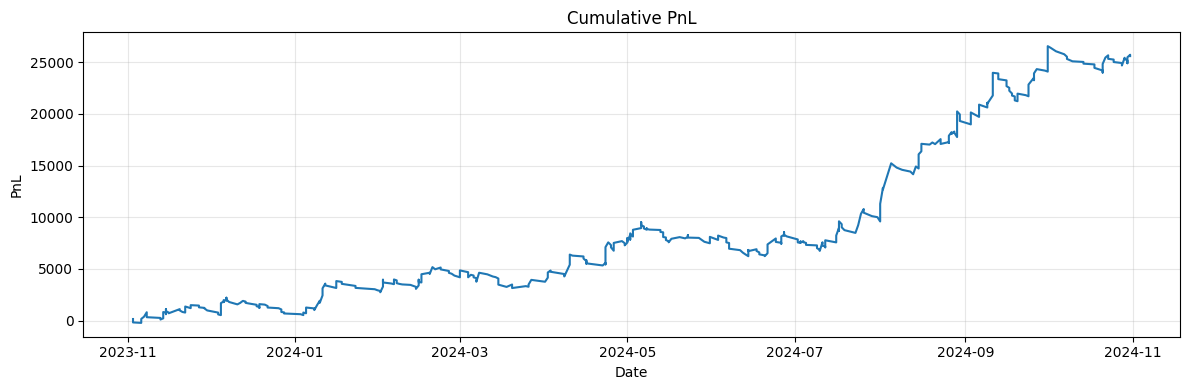

,entry_time,entry_px,side,exit_time,exit_px,reason,pnl_pts,pnl_usd,entry_regime,entry_side_bias,...,entry_DIp60,entry_DIn60,entry_DIp14,entry_DIn14,entry_ADX14_rise,entry_ATR5,entry_ATR60,cum_pnl_usd,date,Date
9,2023-11-03 11:54:00,14964.75,1,2023-11-03 11:58:00,14972.50,target,7.75,155.0,expansion,neutral,...,25.523709,15.259959,26.828390,11.126943,1.034670,4.267706,3.374835,-230.0,2023-11-03,2023-11-03
10,2023-11-03 12:54:00,15052.75,1,2023-11-03 12:55:00,15044.25,stop,-8.50,-170.0,expansion,neutral,...,30.220787,12.948708,26.924703,11.355697,0.784832,9.904654,7.649699,-400.0,2023-11-03,2023-11-03
11,2023-11-03 13:39:00,15062.00,1,2023-11-03 13:39:00,15054.00,stop,-8.00,-160.0,trend_up,long,...,26.042014,16.700502,24.540940,18.724537,-0.987659,13.560400,8.368918,-560.0,2023-11-03,2023-11-03
17,2023-11-06 12:34:00,15206.25,-1,2023-11-06 12:34:00,15208.50,stop,-2.25,-45.0,expansion,neutral,...,22.143829,26.659466,24.372213,31.646377,5.167287,3.810328,2.978319,-60.0,2023-11-06,2023-11-06
18,2023-11-06 13:02:00,15203.50,-1,2023-11-06 13:06:00,15196.50,target,7.00,140.0,expansion,neutral,...,20.613496,25.751785,20.354725,25.702450,3.484425,4.053107,3.090729,80.0,2023-11-06,2023-11-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,2024-10-30 13:13:00,20664.75,-1,2024-10-30 13:14:00,20672.00,stop,-7.25,-145.0,expansion,neutral,...,16.224948,25.719392,17.824909,27.268506,1.889874,10.485826,7.447956,14665.0,2024-10-30,2024-10-30
1483,2024-10-30 13:31:00,20635.00,-1,2024-10-30 13:31:00,20643.00,stop,-8.00,-160.0,neutral,neutral,...,16.181167,25.309209,17.185110,25.139016,-6.895401,9.823295,7.671918,14505.0,2024-10-30,2024-10-30
1484,2024-10-30 14:58:00,20652.50,-1,2024-10-30 15:11:00,20624.00,target,28.50,570.0,expansion,neutral,...,17.208263,18.712809,18.873165,19.624653,3.073648,16.616133,13.039277,15075.0,2024-10-30,2024-10-30
1487,2024-10-31 12:03:00,20378.50,1,2024-10-31 12:04:00,20391.00,target,12.50,250.0,expansion,neutral,...,26.655430,18.933029,28.994903,25.445824,2.141598,7.607909,5.737429,15155.0,2024-10-31,2024-10-31


In [75]:

def trade_stats(df, pnl_col='returns', r_col=None, equity_start=0.0):
    """
    df must have a PnL column (default: 'returns').
    If you also have an R-multiple column, pass its name via r_col.
    Returns (stats_dict, equity_series, drawdown_series).
    """
    # sort (optional, helps equity curve look right)
    if {'Date','timeExit'}.issubset(df.columns):
        df = df.sort_values(['Date','timeExit'])
    s = pd.Series(df[pnl_col].astype(float).values)
    n = int(s.size)
    if n == 0:
        return {}, pd.Series(dtype=float), pd.Series(dtype=float)

    wins   = s[s > 0]
    losses = s[s < 0]

    gross_profit = float(wins.sum())
    gross_loss   = float(-losses.sum())  # positive number

    win_rate  = float(len(wins) / (len(wins) + len(losses)))
    loss_rate = float(len(losses) / (len(wins) + len(losses)))

    avg_win  = float(wins.mean())   if len(wins)   else 0.0
    avg_loss = float(losses.mean()) if len(losses) else 0.0  # negative
    payoff   = (avg_win / abs(avg_loss)) if len(wins) and len(losses) else np.inf

    profit_factor = (gross_profit / gross_loss) if gross_loss > 0 else np.inf
    expectancy    = win_rate * avg_win + loss_rate * avg_loss  # per trade

    equity = pd.Series(equity_start + s.cumsum(), name='equity')
    run_max = equity.cummax()
    drawdown = equity - run_max
    max_dd = float(drawdown.min())  # negative

    std = float(s.std(ddof=1))
    sharpe_per_trade = (float(s.mean() - 0.04) / std * np.sqrt(n)) if std > 0 and n > 1 else np.nan

    stats = {
        'n_trades': n,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,                 # negative number
        'payoff_ratio': payoff,               # |avg_win| / |avg_loss|
        'expectancy_per_trade': expectancy,   # same units as returns
        'gross_profit': gross_profit,
        'gross_loss': gross_loss,
        'profit_factor': profit_factor,
        'total_pnl': float(s.sum()),
        'median_pnl': float(s.median()),
        'max_drawdown': max_dd,               # same units as returns
        'sharpe_per_trade': sharpe_per_trade
    }

    if r_col and r_col in df.columns:
        r = df[r_col].astype(float)
        stats.update({
            'avg_R': float(r.mean()),
            'median_R': float(r.median()),
            'total_R': float(r.sum()),
            'win_rate_Rpos': float((r > 0).mean())
        })

    return stats #, equity, drawdown


stats = trade_stats(test1, pnl_col='pnl_usd')
print(pd.Series(stats))



test1['date'] = test1['entry_time'].dt.date
temp = test1.copy(deep=True)

if 'date' in temp.columns:
    temp['Date'] = pd.to_datetime(temp['date'], errors='coerce')
    df = temp.sort_values('date')

r = pd.to_numeric(df['pnl_usd'], errors='coerce').fillna(0)

# 1) Cumulative PnL (use for per-trade PnL/points)
df['cum_pnl'] = r.cumsum()


import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df['Date'] if 'Date' in df.columns else df.index, df['cum_pnl'])
plt.title('Cumulative PnL')
plt.xlabel('Date' if 'Date' in df.columns else 'Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

temp

In [ ]:
import pandas as pd
import numpy as np

# ================== v3 PARAMETERS (tweak here) ==================
TICK_SIZE        = 0.25
POINT_VALUE      = 20.0      # NQ = $20/pt (use 2.0 for MNQ)
ATR_LEN          = 14
STOP_MULT        = 0.75      # stop = 0.75 * ATR
TARGET_MULT      = 2.0       # target = 2.0 * ATR
MOUTH_GAP_MULT   = 0.20      # mouth gaps must exceed 0.20 * ATR (was 0.15)
SLOPE_GATE_MULT  = 0.10      # |EMA200 slope over last 10 bars| > 0.15 * ATR
SLIPPAGE_TICKS   = 2.0       # next-bar-open entry slippage
SESSION_START    = "09:45:00"
SESSION_END      = "15:55:00"
COOLDOWN_AFTER_LOSS = 2      # skip next K signals after a stop
# ================================================================

# ---------- Indicators ----------
def smma(x: pd.Series, n: int) -> pd.Series:
    s = x.astype(float).copy()
    out = pd.Series(index=s.index, dtype=float)
    alpha = 1.0 / n
    prev = np.nan
    for i, v in enumerate(s.values):
        if i == 0 or np.isnan(prev):
            prev = v
        else:
            prev = prev + alpha * (v - prev)
        out.iat[i] = prev
    return out

def ema(x: pd.Series, n: int) -> pd.Series:
    return x.astype(float).ewm(span=n, adjust=False).mean()

def true_range(df: pd.DataFrame) -> pd.Series:
    pc = df["close"].shift(1)
    tr1 = df["high"] - df["low"]
    tr2 = (df["high"] - pc).abs()
    tr3 = (df["low"]  - pc).abs()
    return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

def atr(df: pd.DataFrame, n: int = 14) -> pd.Series:
    return smma(true_range(df), n)

# ---------- Prep ----------
def normalize_from_date_time(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["datetime"] = pd.to_datetime(out["Date"].astype(str) + " " + out["Time"].astype(str))
    for c in ["open","high","low","close","volume"]:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    out = out.dropna(subset=["open","high","low","close"]).sort_values("datetime").reset_index(drop=True)
    return out

# ---------- Backtest v3 ----------
def backtest_alligator_v3(
    raw_df: pd.DataFrame,
    tick_size=TICK_SIZE,
    point_value=POINT_VALUE,
    atr_len=ATR_LEN,
    stop_mult=STOP_MULT,
    target_mult=TARGET_MULT,
    mouth_gap_mult=MOUTH_GAP_MULT,
    slope_gate_mult=SLOPE_GATE_MULT,
    slippage_ticks=SLIPPAGE_TICKS,
    session_start=SESSION_START,
    session_end=SESSION_END,
    cooldown_after_loss=COOLDOWN_AFTER_LOSS
):
    df = normalize_from_date_time(raw_df)

    # Indicators
    df["ema200"] = ema(df["close"], 200)
    df["jaw"]    = smma(df["close"], 13)   # unshifted for signals
    df["teeth"]  = smma(df["close"], 8)
    df["lips"]   = smma(df["close"], 5)
    df["atr"]    = atr(df, atr_len)

    # EMA slope over last 10 bars
    df["ema_slope"] = df["ema200"] - df["ema200"].shift(10)

    # Intraday window
    t = df["datetime"].dt.time
    df = df[(t >= pd.to_datetime(session_start).time()) & (t <= pd.to_datetime(session_end).time())].copy()
    df.reset_index(drop=True, inplace=True)
    if len(df) < 50:
        return pd.DataFrame(), pd.Series({"n_trades": 0})

    trades = []
    in_pos = False
    side = 0
    entry_px = np.nan
    entry_time = None
    stop_px = np.nan
    tgt_px = np.nan
    cooldown = 0

    for i in range(1, len(df)-1):
        prev = df.iloc[i-1]
        row  = df.iloc[i]
        nxt  = df.iloc[i+1]

        # Manage open position
        if in_pos:
            exit_px = None
            reason = None
            if side == 1:
                if row["low"] <= stop_px:
                    exit_px, reason = stop_px, "stop"
                elif row["high"] >= tgt_px:
                    exit_px, reason = tgt_px, "target"
            else:
                if row["high"] >= stop_px:
                    exit_px, reason = stop_px, "stop"
                elif row["low"] <= tgt_px:
                    exit_px, reason = tgt_px, "target"

            if exit_px is not None:
                exit_px = round(exit_px / tick_size) * tick_size
                pnl_pts = (exit_px - entry_px) * side
                pnl_usd = pnl_pts * point_value
                trades.append({
                    "entry_time": entry_time, "entry_px": entry_px, "side": side,
                    "exit_time": row["datetime"], "exit_px": exit_px, "reason": reason,
                    "pnl_pts": pnl_pts, "pnl_usd": pnl_usd
                })
                # Cooldown on loss
                if reason == "stop":
                    cooldown = cooldown_after_loss
                in_pos = False
                side = 0
                continue

        # Entries only if flat
        if not in_pos:
            # Cooldown management
            if cooldown > 0:
                cooldown -= 1
                continue

            if row["atr"] <= 0 or pd.isna(row["atr"]):
                continue

            bias_long  = (row["close"] > row["ema200"]) and (row["ema_slope"] > 0)
            bias_short = (row["close"] < row["ema200"]) and (row["ema_slope"] < 0)

            # Mouth open with ATR gap requirement
            mouth_up = (row["lips"] > row["teeth"]) and (row["teeth"] > row["jaw"]) \
                       and ((row["lips"] - row["teeth"]) > mouth_gap_mult*row["atr"]) \
                       and ((row["teeth"] - row["jaw"])  > mouth_gap_mult*row["atr"])

            mouth_dn = (row["lips"] < row["teeth"]) and (row["teeth"] < row["jaw"]) \
                       and ((row["teeth"] - row["lips"]) > mouth_gap_mult*row["atr"]) \
                       and ((row["jaw"]  - row["teeth"]) > mouth_gap_mult*row["atr"])

            crossed_up = (prev["close"] <= prev["teeth"]) and (row["close"] > row["teeth"])
            crossed_dn = (prev["close"] >= prev["teeth"]) and (row["close"] < row["teeth"])

            # Slope magnitude gate
            slope_gate = abs(row["ema_slope"]) > slope_gate_mult * row["atr"]

            # Long
            if bias_long and mouth_up and crossed_up and slope_gate:
                raw = float(nxt["open"])
                entry_px = round((raw + slippage_ticks * tick_size) / tick_size) * tick_size
                side = 1
                entry_time = nxt["datetime"]
                stop_px = entry_px - stop_mult * row["atr"]
                tgt_px  = entry_px + target_mult * row["atr"]
                in_pos = True
                continue

            # Short
            if bias_short and mouth_dn and crossed_dn and slope_gate:
                raw = float(nxt["open"])
                entry_px = round((raw - slippage_ticks * tick_size) / tick_size) * tick_size
                side = -1
                entry_time = nxt["datetime"]
                stop_px = entry_px + stop_mult * row["atr"]
                tgt_px  = entry_px - target_mult * row["atr"]
                in_pos = True
                continue

    # Results
    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        summary = pd.Series({
            "n_trades": 0, "win_rate": np.nan,
            "total_pnl_pts": 0.0, "total_pnl_usd": 0.0,
            "avg_pnl_pts": np.nan, "max_drawdown_usd": 0.0
        })
        return trades_df, summary

    trades_df["cum_pnl_usd"] = trades_df["pnl_usd"].cumsum()
    roll_max = trades_df["cum_pnl_usd"].cummax()
    dd = trades_df["cum_pnl_usd"] - roll_max
    summary = pd.Series({
        "n_trades": int(len(trades_df)),
        "win_rate": float((trades_df["pnl_usd"] > 0).mean()),
        "total_pnl_pts": float(trades_df["pnl_pts"].sum()),
        "total_pnl_usd": float(trades_df["pnl_usd"].sum()),
        "avg_pnl_pts": float(trades_df["pnl_pts"].mean()),
        "max_drawdown_usd": float(dd.min())
    })
    return trades_df, summary

# -------- RUN v3 on your NQ_Data --------
trades3, summary3 = backtest_alligator_v3(NQ_Data)
print("=== SUMMARY v3 (ATR + slope gate + cooldown) ===")
print(summary3)
print("\nSample trades:")
trades3


In [ ]:
def sweep_v3(NQ_Data):
    i = 0
    rows = []
    for stop_mult in [0.75]:
        for target_mult in [2.0, 2.5, 3.0]:
            for mouth_gap in [0.20, 0.25]:
                for slope_mult in [0.10, 0.15]:
                    for cooldown in [3]:
                        print(i)
                        i= i+1
                        tr, sm = backtest_alligator_v3(
                            NQ_Data,
                            stop_mult=stop_mult,
                            target_mult=target_mult,
                            mouth_gap_mult=mouth_gap,
                            slope_gate_mult=slope_mult,
                            slippage_ticks=2.0,
                            cooldown_after_loss=cooldown
                        )
                        rows.append({
                            "stop_mult": stop_mult,
                            "target_mult": target_mult,
                            "mouth_gap": mouth_gap,
                            "slope_mult": slope_mult,
                            "cooldown": cooldown,
                            "n_trades": sm["n_trades"],
                            "win_rate": sm["win_rate"],
                            "avg_pts": sm["avg_pnl_pts"],
                            "total_usd": sm["total_pnl_usd"],
                            "max_dd": sm["max_drawdown_usd"]
                        })
    return pd.DataFrame(rows).sort_values(["total_usd","max_dd"], ascending=[False, True])

grid = sweep_v3(NQ_Data)
print(grid.head(15))


In [ ]:
grid

In [ ]:
grid